In [1]:
import pandas as pd
import numpy as np




In [ ]:
# Global constants
DATA_PATH = 'task_2.csv.zip'
MIN_INTERACTIONS = 5
K_VALUES = [5, 10, 20]

# Part 1

## 1. Data Preprocessing

In [3]:
#Load Data
df = pd.read_csv(DATA_PATH)
# Display first few rows
df.head()

/var/folders/nb/652qhdw11_x4ktggsx1j8py00000gn/T/ipykernel_13296/525558668.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)


,user_id,item_id,click,follow,like,share,video_category,watching_times,gender,age
0,3502303,1357499,1,0,0,0,1,4,0,0
1,3502303,1354715,1,0,0,0,1,2,0,0
2,3502303,58416,1,0,0,0,1,2,0,0
3,3502303,1362524,1,0,0,0,1,7,0,0
4,3502303,1353039,1,0,0,0,1,3,0,0


In [4]:
def preprocess_data(df):
    # Filter users with fewer than 5 interactions
    user_counts = df['user_id'].value_counts()
    active_users = user_counts[user_counts >= MIN_INTERACTIONS].index
    df = df[df['user_id'].isin(active_users)]

    # Filter items with fewer than 5 interactions
    item_counts = df['item_id'].value_counts()
    active_items = item_counts[item_counts >= MIN_INTERACTIONS].index
    df = df[df['item_id'].isin(active_items)]
    
    # Create sequential timestamp based on original order
    df["timestamp"] = df.groupby("user_id").cumcount()
    
    # Sort interactions by user_id and the new timestamp
    df = df.sort_values(by=['user_id', 'timestamp'])
    
    return df

df = preprocess_data(df)
df

,user_id,item_id,click,follow,like,share,video_category,watching_times,gender,age,timestamp
45678,2138,1524428,1,0,0,0,1,2,0,0,0
45684,2138,1831290,1,0,0,0,1,4,0,0,1
45688,2138,1377452,1,0,0,0,1,6,0,0,2
45690,2138,3122021,1,0,0,0,1,2,0,0,3
45693,2138,3004558,1,0,0,0,1,4,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...
82393,6277894,1353015,1,0,0,0,1,1,1,2,4
82394,6277894,36174,1,0,0,0,1,2,1,2,5
82395,6277894,1371484,1,0,0,0,0,3,1,2,6
82396,6277894,1585472,1,0,0,0,1,1,1,2,7


## 2. Train/Test Split (Leave-One-Out)

For each user:
- Use all but the last interaction as the training set.
- Use the last interaction as the test set.

In [5]:
def train_test_split(df):
    df = df.sort_values(["user_id", "timestamp"])
    test = df.groupby("user_id").tail(1)
    test_idx = test.index
    train = df.loc[~df.index.isin(test_idx)]
    return train, test

train, test = train_test_split(df)
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

In [6]:
train = pd.read_csv('train.csv')
train

/var/folders/nb/652qhdw11_x4ktggsx1j8py00000gn/T/ipykernel_13296/1926814385.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('train.csv')


,user_id,item_id,click,follow,like,share,video_category,watching_times,gender,age,timestamp
0,2138,1524428,1,0,0,0,1,2,0,0,0
1,2138,1831290,1,0,0,0,1,4,0,0,1
2,2138,1377452,1,0,0,0,1,6,0,0,2
3,2138,3122021,1,0,0,0,1,2,0,0,3
4,2138,3004558,1,0,0,0,1,4,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...
215157,6277894,3258896,1,0,0,0,1,4,1,2,3
215158,6277894,1353015,1,0,0,0,1,1,1,2,4
215159,6277894,36174,1,0,0,0,1,2,1,2,5
215160,6277894,1371484,1,0,0,0,0,3,1,2,6


## 3. Baseline Models

### A. Popularity-Based Recommender
Recommends the items with the highest overall number of interactions.

In [7]:
def already_seen(train_df, user_id):
    """ Returns a set of items already seen by the user
    """
    return train_df[train_df['user_id'] == user_id]['item_id'].tolist()

def recommend_popularity(train_df, user_id, k):
    """
    Recommend the top-k most popular items the user has not interacted with.

    Inputs
    ----------
    train_df : pandas.DataFrame
    user_id: User for whom we want recommendations.
    k : Number of items to recommend.

    Returns
    -------
    list: A list of item_ids of length k (or fewer if not enough items exist).
    """
    seen = already_seen(train_df, user_id)
    popular = train_df['item_id'].value_counts().index.tolist()
    
    recs = []
    for item in popular:
        if item not in seen:
            recs.append(item)
            if len(recs) == k:
                break
    return recs

# Test the popularity-based recommender
test_user = test['user_id'].iloc[0]
recommendations = recommend_popularity(train, test_user, k=10)
print(f"Top 10 recommendations for user {test_user}:")
print(recommendations)


   

Top 10 recommendations for user 2138:
[3202485, 3202480, 1721814, 3203433, 1363795, 3203817, 1401565, 3202852, 1371484, 1596438]


### B. Item–Item Similarity Recommender
Recommends items that commonly co-occur with the user's history.

In [8]:
def build_cooccurrence_matrix(train_df):
    """
    Build a co-occurrence matrix: for each item, count how many times 
    it appears with other items in the same user's history.
    
    Returns a dict: item_id -> dict of co-occurring items and their counts
    """
    cooccur = {}
    
    # Build user_items manually
    user_items = {}
    for user_id, item_id in zip(train_df['user_id'], train_df['item_id']):
        if user_id not in user_items:
            user_items[user_id] = []
        user_items[user_id].append(item_id)
    
    # For each user's history, count co-occurrences
    for items in user_items.values():
        for i in range(len(items)):
            item_i = items[i]
            
            # Initialize if not seen before
            if item_i not in cooccur:
                cooccur[item_i] = {}
            
            for j in range(len(items)):
                if i != j:
                    item_j = items[j]
                    
                    # Count co-occurrence
                    if item_j not in cooccur[item_i]:
                        cooccur[item_i][item_j] = 0
                    cooccur[item_i][item_j] += 1
    
    return cooccur

def recommend_item_similarity(train_df, user_id, k, cooccur_matrix):
    """
    Recommend top-k items based on co-occurrence with user's history.
    """
    seen = already_seen(train_df, user_id)
    
    # Get user's interaction history
    user_items = list(train_df.loc[train_df['user_id'] == user_id, 'item_id'])
    
    # If user has no history, return empty list
    if not user_items:
        return []
    
    # Score items based on co-occurrence with user's history
    item_scores = {}
    for item in user_items:
        if item in cooccur_matrix:
            for cooccur_item, count in cooccur_matrix[item].items():
                if cooccur_item not in seen:
                    item_scores[cooccur_item] = item_scores.get(cooccur_item, 0) + count
    
    # Sort by score and get top-k
    if not item_scores:
        return []
    
    sorted_items = sorted(item_scores.items(), key=lambda x: x[1], reverse=True)
    top_k = [item_id for item_id, score in sorted_items[:k]]
    
    return top_k

# Build co-occurrence matrix once
print("Building co-occurrence matrix...")
cooccur_matrix = build_cooccurrence_matrix(train)
print(f"Co-occurrence matrix built with {len(cooccur_matrix)} items")

# Test the item-item similarity recommender
test_user = test['user_id'].iloc[0]
recommendations = recommend_item_similarity(train, test_user, k=10, cooccur_matrix=cooccur_matrix)
print(f"Top 10 item-similarity recommendations for user {test_user}:")
print(recommendations)

Building co-occurrence matrix...
Co-occurrence matrix built with 10578 items
Top 10 item-similarity recommendations for user 2138:
[1357499, 1368037, 345327, 58416, 3272617, 1354597, 180624, 306, 10620, 1420228]


## 4. Evaluation Metrics

Required metric: Recall@K

In [9]:
def recall_at_k(recommended_items, true_item, k):
    """
    Compute Recall@K for a single user.
    """
    if true_item in recommended_items[:k]:
        return 1.0
    return 0.0

def evaluate_model(recommend_func, train_df, test_df, k_values, cooccur_matrix=None):
    """
    Evaluate a recommendation model using Recall@K.
    """
    results = {k: [] for k in k_values}
    
    total_users = len(test_df)
    print(f"Evaluating {total_users} users...")
    
    # For each test user
    for count, (idx, row) in enumerate(test_df.iterrows(), 1):
        if count % 500 == 0:
            print(f"  Progress: {count}/{total_users} users evaluated...")
        
        user_id = row['user_id']
        true_item = row['item_id']
        
        # Get recommendations (generate enough for the largest K)
        max_k = max(k_values)
        
        # Call function with or without cooccur_matrix
        if cooccur_matrix is not None:
            recommendations = recommend_func(train_df, user_id, max_k, cooccur_matrix)
        else:
            recommendations = recommend_func(train_df, user_id, max_k)
        
        # Compute recall for each K
        for k in k_values:
            recall = recall_at_k(recommendations, true_item, k)
            results[k].append(recall)
    
    # Average recall for each K
    avg_results = {k: np.mean(results[k]) for k in k_values}
    return avg_results

In [10]:
# Evaluate Popularity-Based Recommender
print("Evaluating Popularity-Based Recommender...")
pop_results = evaluate_model(recommend_popularity, train, test, K_VALUES)
print("Popularity-Based Results:")
for k, recall in pop_results.items():
    print(f"  Recall@{k}: {recall:.4f}")

# Evaluate Item-Item Similarity Recommender
print("\nEvaluating Item-Item Similarity Recommender...")
sim_results = evaluate_model(recommend_item_similarity, train, test, K_VALUES, cooccur_matrix=cooccur_matrix)
print("Item-Item Similarity Results:")
for k, recall in sim_results.items():
    print(f"  Recall@{k}: {recall:.4f}")

# Compare results
print("\n" + "="*50)
print("Comparison:")
print("="*50)
for k in K_VALUES:
    print(f"K={k}:")
    print(f"  Popularity:     {pop_results[k]:.4f}")
    print(f"  Item-Similarity: {sim_results[k]:.4f}")
    print()

Evaluating Popularity-Based Recommender...
Evaluating 3059 users...
  Progress: 500/3059 users evaluated...
  Progress: 1000/3059 users evaluated...
  Progress: 1500/3059 users evaluated...
  Progress: 2000/3059 users evaluated...
  Progress: 2500/3059 users evaluated...
  Progress: 3000/3059 users evaluated...
Popularity-Based Results:
  Recall@5: 0.0154
  Recall@10: 0.0235
  Recall@20: 0.0510

Evaluating Item-Item Similarity Recommender...
Evaluating 3059 users...
  Progress: 500/3059 users evaluated...
  Progress: 1000/3059 users evaluated...
  Progress: 1500/3059 users evaluated...
  Progress: 2000/3059 users evaluated...
  Progress: 2500/3059 users evaluated...
  Progress: 3000/3059 users evaluated...
Item-Item Similarity Results:
  Recall@5: 0.0235
  Recall@10: 0.0428
  Recall@20: 0.0690

Comparison:
K=5:
  Popularity:     0.0154
  Item-Similarity: 0.0235

K=10:
  Popularity:     0.0235
  Item-Similarity: 0.0428

K=20:
  Popularity:     0.0510
  Item-Similarity: 0.0690



# Part2: Matrix Factorization


## 1. Negative Sampling and Preprocessing


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader



# Reindex users and items for embeddings
def create_mappings(train_df):
    """
    Create mappings from original IDs to sequential indices for embeddings.
    """
    unique_users = train_df['user_id'].unique()
    unique_items = train_df['item_id'].unique()
    
    user_to_idx = {user_id: idx for idx, user_id in enumerate(unique_users)}
    item_to_idx = {item_id: idx for idx, item_id in enumerate(unique_items)}
    
    idx_to_user = {idx: user_id for user_id, idx in user_to_idx.items()}
    idx_to_item = {idx: item_id for item_id, idx in item_to_idx.items()}
    
    return user_to_idx, item_to_idx, idx_to_user, idx_to_item

user_to_idx, item_to_idx, idx_to_user, idx_to_item = create_mappings(train)

print(f"Number of unique users: {len(user_to_idx)}")
print(f"Number of unique items: {len(item_to_idx)}")

def negative_sampling(train_df, user_to_idx, item_to_idx):
    """
    Create negative samples for implicit feedback.
    For each positive interaction, sample one negative item.
    
    Returns:
    - Three numpy arrays: user_indices, item_indices, labels
    """
    all_items = list(item_to_idx.keys())
    
    user_list = []
    item_list = []
    label_list = []
    
    # For each positive interaction
    for idx, row in train_df.iterrows():
        user_id = row['user_id']
        pos_item = row['item_id']
        
        # Add positive sample
        user_list.append(user_to_idx[user_id])
        item_list.append(item_to_idx[pos_item])
        label_list.append(1)
        
        # Sample negative item
        neg_item = np.random.choice(all_items)
        
        # Add negative sample
        user_list.append(user_to_idx[user_id])
        item_list.append(item_to_idx[neg_item])
        label_list.append(0)
    
    return np.array(user_list), np.array(item_list), np.array(label_list)

# Generate negative samples
train_user, train_item, train_label = negative_sampling(train, user_to_idx, item_to_idx)

print(f"Training samples: {len(train_user)}")
print(f"Positive samples: {train_label.sum()}")
print(f"Negative samples: {len(train_label) - train_label.sum()}")







Number of unique users: 3051
Number of unique items: 10578
Training samples: 430324
Positive samples: 215162
Negative samples: 215162


## MF Model

In [12]:
class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=50):
        super(MatrixFactorization, self).__init__()
        # User and item embedding matrices
        self.user_embeddings = nn.Embedding(num_users, embedding_dim)
        self.item_embeddings = nn.Embedding(num_items, embedding_dim)
        
    def forward(self, user_ids, item_ids):
        # Get embeddings
        user_embeds = self.user_embeddings(user_ids)
        item_embeds = self.item_embeddings(item_ids)
        # Compute dot product
        ratings = (user_embeds * item_embeds).sum(dim=1)
        return ratings

## Training

In [13]:
# Convert to tensors
user_tensor = torch.from_numpy(train_user).long()
item_tensor = torch.from_numpy(train_item).long()
label_tensor = torch.from_numpy(train_label).float()

# Create dataset and dataloader
dataset = TensorDataset(user_tensor, item_tensor, label_tensor)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)

# Initialize model
num_users = len(user_to_idx)
num_items = len(item_to_idx)
embedding_dim = 50

model = MatrixFactorization(num_users, num_items, embedding_dim)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
print("Training Matrix Factorization Model...")

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for batch_users, batch_items, batch_labels in dataloader:
        # Forward pass
        predictions = model(batch_users, batch_items)
        loss = criterion(predictions, batch_labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

print("Training complete!")

Training Matrix Factorization Model...
Epoch 1/10, Loss: 2.8476
Epoch 2/10, Loss: 2.5926
Epoch 3/10, Loss: 2.3586
Epoch 4/10, Loss: 2.1455
Epoch 5/10, Loss: 1.9532
Epoch 6/10, Loss: 1.7788
Epoch 7/10, Loss: 1.6209
Epoch 8/10, Loss: 1.4790
Epoch 9/10, Loss: 1.3509
Epoch 10/10, Loss: 1.2351
Training complete!


## Generate recommendations

In [14]:
def recommend_model(train_df, user_id, k, model, user_to_idx, item_to_idx, idx_to_item):
    """
    Generate top-k recommendations using the trained model.
    """
    model.eval()
    
    # Get user index
    if user_id not in user_to_idx:
        return []
    
    user_idx = user_to_idx[user_id]
    
    # Get items already seen by user
    seen = already_seen(train_df, user_id)
    
    # Get all item indices
    all_item_indices = list(range(len(item_to_idx)))
    
    # Create tensors for scoring
    user_indices = torch.tensor([user_idx] * len(all_item_indices)).long()
    item_indices = torch.tensor(all_item_indices).long()
    
    # Get predictions
    with torch.no_grad():
        scores = model(user_indices, item_indices).numpy()
    
    # Create list of (item_id, score) pairs for unseen items
    candidates = []
    for item_idx, score in enumerate(scores):
        item_id = idx_to_item[item_idx]
        if item_id not in seen:
            candidates.append((item_id, score))
    
    # Sort by score and get top-k
    candidates.sort(key=lambda x: x[1], reverse=True)
    top_k = [item_id for item_id, score in candidates[:k]]
    
    return top_k

# Test the model recommender
test_user = test['user_id'].iloc[0]
recommendations = recommend_model(train, test_user, k=10, model=model, 
                                  user_to_idx=user_to_idx, item_to_idx=item_to_idx, 
                                  idx_to_item=idx_to_item)
print(f"\nTop 10 MF recommendations for user {test_user}:")
print(recommendations)



Top 10 MF recommendations for user 2138:
[np.int64(1406759), np.int64(3207908), np.int64(3279557), np.int64(1365627), np.int64(3261395), np.int64(3213981), np.int64(1433995), np.int64(3218102), np.int64(3202831), np.int64(3226917)]


## Evals

In [15]:
### 5. Evaluation

print("\nEvaluating Matrix Factorization Model...")
mf_results = evaluate_model(
    lambda train_df, user_id, k: recommend_model(train_df, user_id, k, model, user_to_idx, item_to_idx, idx_to_item),
    train, test, K_VALUES
)
print("Matrix Factorization Results:")
for k, recall in mf_results.items():
    print(f"  Recall@{k}: {recall:.4f}")

# Final Comparison
print("\n" + "="*60)
print("FINAL COMPARISON - All Models")
print("="*60)
for k in K_VALUES:
    print(f"\nRecall@{k}:")
    print(f"  Popularity:          {pop_results[k]:.4f}")
    print(f"  Item-Similarity:     {sim_results[k]:.4f}")
    print(f"  Matrix Factorization: {mf_results[k]:.4f}")



Evaluating Matrix Factorization Model...
Evaluating 3059 users...
  Progress: 500/3059 users evaluated...
  Progress: 1000/3059 users evaluated...
  Progress: 1500/3059 users evaluated...
  Progress: 2000/3059 users evaluated...
  Progress: 2500/3059 users evaluated...
  Progress: 3000/3059 users evaluated...
Matrix Factorization Results:
  Recall@5: 0.0007
  Recall@10: 0.0010
  Recall@20: 0.0023

FINAL COMPARISON - All Models

Recall@5:
  Popularity:          0.0154
  Item-Similarity:     0.0235
  Matrix Factorization: 0.0007

Recall@10:
  Popularity:          0.0235
  Item-Similarity:     0.0428
  Matrix Factorization: 0.0010

Recall@20:
  Popularity:          0.0510
  Item-Similarity:     0.0690
  Matrix Factorization: 0.0023


## Visualization

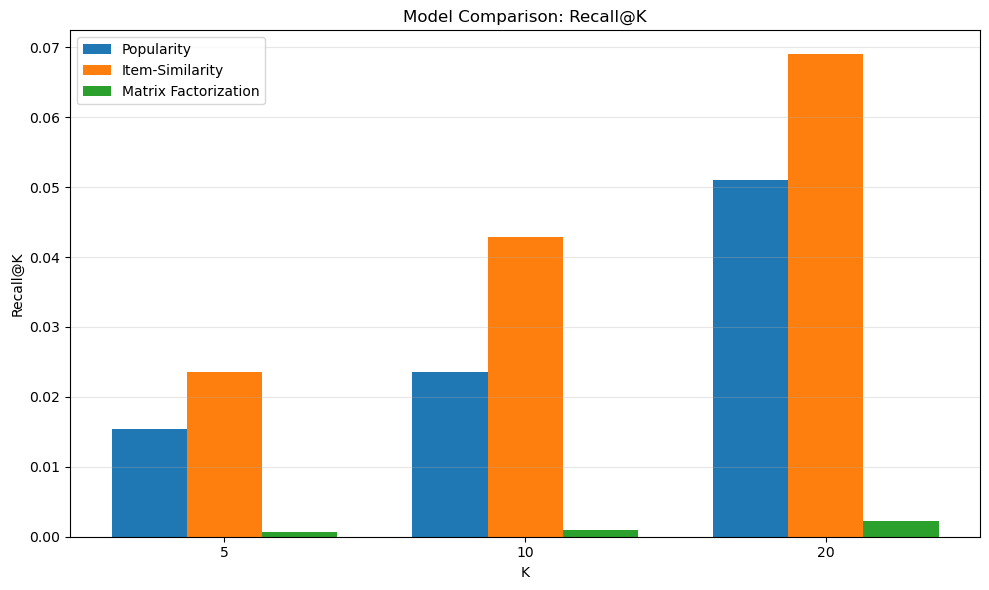

In [18]:
import matplotlib.pyplot as plt

# Prepare data
pop_scores = [pop_results[k] for k in K_VALUES]
sim_scores = [sim_results[k] for k in K_VALUES]
mf_scores = [mf_results[k] for k in K_VALUES]

# Create bar chart
x = np.arange(len(K_VALUES))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, pop_scores, width, label='Popularity')
plt.bar(x, sim_scores, width, label='Item-Similarity')
plt.bar(x + width, mf_scores, width, label='Matrix Factorization')

plt.xlabel('K')
plt.ylabel('Recall@K')
plt.title('Model Comparison: Recall@K')
plt.xticks(x, K_VALUES)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()